In [624]:
import numpy
import sklearn
import scipy
import sys
import io
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np
from scipy.optimize import minimize
import matplotlib
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import torch.utils.data as data_utils
import torch
from itertools import product
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.preprocessing import StandardScaler
import torchvision
from torchvision.transforms import transforms
from sklearn.decomposition import PCA, FastICA
from ERM import sklearn_optimize, error, adversarial_error
from helpers import ProblemType
from data_model import KFeaturesModel
import pickle
from collections import namedtuple
import os
from pathlib import Path
from dataclasses import dataclass, make_dataclass
from functools import wraps

import logging
logger = logging.getLogger()


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [625]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [626]:
plt.style.use("latex_ready.mplstyle")

In [627]:
def cifar10_plot(ax, im, label):
    
    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    
    ax.imshow(img,  interpolation='nearest') 
    if hasattr(ax,"set_title"):
        ax.set_title(label)
    elif hasattr(ax,"title"):
        ax.title(label)
    else:
        raise ValueError("Unable to set title")
    ax.axis("off")

In [628]:
def plot_cifar10_subset(data, labels, subset: str):
    # display some random images from both classes including a label for each image
    fig, ax = plt.subplots(2, 5)
    fig.suptitle(f"Random images from the {subset} dataset")
    for i in range(2):
        for j in range(5):
            idx = np.random.randint(0, data.shape[0])
            

            cifar10_plot(ax[i, j], data[idx], labels[idx])               
                       
            
    plt.show()

In [629]:
FIRST_LABEL = 3
SECOND_LABEL = 1
def preprocess_cifar10_data_labels(data, labels, subset):
    labels = np.array(labels)
    data = np.array(data)
    
    print(subset, labels.shape, data.shape)

    mask = (labels == FIRST_LABEL) | (labels == SECOND_LABEL)
    label_subset = labels[mask]
    data_subset = data[mask]
        
    mask_first = label_subset == FIRST_LABEL
    mask_second = label_subset == SECOND_LABEL
    
    # label the FIRST_LABEL as 1
    # label the SECOND_LABEL as -1
    label_subset[mask_first] = 1
    label_subset[mask_second] = -1

    plot_cifar10_subset(data_subset, label_subset, subset)    

    return data_subset, label_subset


In [630]:
def prepare_cifar10_data():
    # get test data
    cifar_10_test_data = unpickle("./data/cifar-10-batches-py/test_batch")[b"data"]
    cifar_10_test_labels = unpickle("./data/cifar-10-batches-py/test_batch")[b"labels"]

    cifar_10_test_data, cifar_10_test_labels = preprocess_cifar10_data_labels(cifar_10_test_data, cifar_10_test_labels, "test:")

    # merge train data
    cifar_10_data = []
    cifar_10_labels = []
    for i in range(1,6):
        data = unpickle("./data/cifar-10-batches-py/data_batch_"+str(i))
        cifar_10_data.append(data[b'data'])
        cifar_10_labels += data[b'labels']
    cifar_10_data = np.concatenate(cifar_10_data)

    cifar_10_data, cifar_10_labels = preprocess_cifar10_data_labels(cifar_10_data, cifar_10_labels, "train:")

    X = StandardScaler().fit(cifar_10_data).transform(cifar_10_data)
    X_test = StandardScaler().fit(cifar_10_test_data).transform(cifar_10_test_data)
    
    # Convert to grayscale by taking the mean:
    X_test = X_test.reshape(len(X_test),32*32,3).mean(axis=2)
    X = X.reshape(len(X),32*32,3).mean(axis=2)

    # print final shape info
    print("Shape X", X.shape)
    print("Shape X_test", X_test.shape)

    return X, X_test, cifar_10_labels, cifar_10_test_labels

test: (10000,) (10000, 3072)


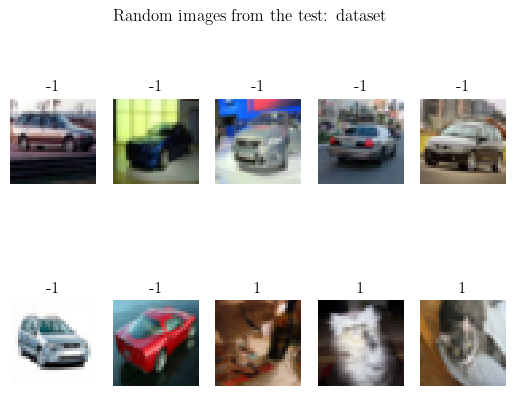

train: (50000,) (50000, 3072)


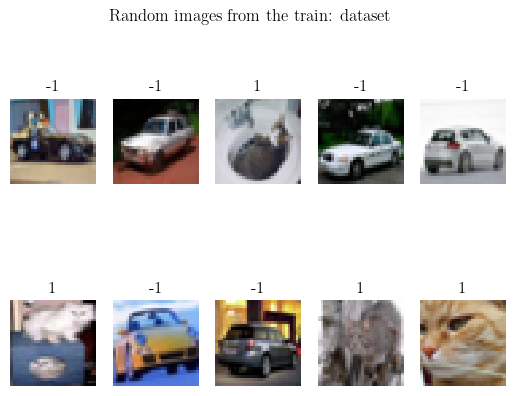

Shape X (10000, 1024)
Shape X_test (2000, 1024)


In [631]:
X, X_test, y, y_test = prepare_cifar10_data()

# Setup

In [632]:
# Custom class to write to both the original stream and a StringIO object
class DualStream:
    def __init__(self, original, capture):
        self.original = original
        self.capture = capture

    def write(self, message):
        # Write to both the original stream and the capture object
        self.original.write(message)
        self.capture.write(message)

    def flush(self):
        # Flush both streams to ensure all output is displayed
        self.original.flush()
        self.capture.flush()

# Decorator to capture stdout and stderr while still printing them
def capture_output_decorator(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        # Create StringIO objects to capture the output
        captured_stdout = io.StringIO()
        captured_stderr = io.StringIO()

        # Save the original stdout and stderr
        original_stdout = sys.stdout
        original_stderr = sys.stderr

        # Create dual streams to capture and print simultaneously
        dual_stdout = DualStream(original_stdout, captured_stdout)
        dual_stderr = DualStream(original_stderr, captured_stderr)

        try:
            # Redirect stdout and stderr to the dual streams
            sys.stdout = dual_stdout
            sys.stderr = dual_stderr

            # Call the original function and capture its result
            result = func(*args, **kwargs)

        finally:
            # Restore original stdout and stderr
            sys.stdout = original_stdout
            sys.stderr = original_stderr

        # Get the captured output
        stdout_output = captured_stdout.getvalue()
        stderr_output = captured_stderr.getvalue()


        if not hasattr(result,"stdout"):
            raise ValueError("Result object has no attr stdout that can be set")
        
        if not hasattr(result,"stderr"):
            raise ValueError("Result object has no attr stderr that can be set")

        result.stdout = stdout_output
        result.stderr = stderr_output

        return result

    return wrapper

In [633]:
def read_object_from_pickle(filename):
    with open(filename, "rb") as f:
        o = pickle.load(f)
        return o
        

def write_object_to_pickle(o, filename):
    with open(filename, 'wb') as file:
            pickle.dump(o, file)

In [666]:
FUNCTION_KWARGS_TO_FILENAME_MAP = {
    "get_experiment_instance": {"dataset_name", "lam", "epsilon", "attack_epsilon", "n_components", "dimensionality_reduction_type"},
    "ica_fit_transform": {"dataset_name", "n_components", "whiten"},
    "pca_fit_transform": {"dataset_name", "n_components"},
}

def serialize_output_to_file(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
    
        key_set = FUNCTION_KWARGS_TO_FILENAME_MAP.get(func.__name__, {})

        print(f"Calling {func.__name__} with keyset {key_set}")

        if not key_set:
            raise ValueError(f"Serializing output of function {func.__name__} without specified 'FUNCTIOn_KWARGS_TO_FILENAME_MAP'")

        # Create a filename from kwargs by joining key-value pairs
        filename = '_'.join(f"{key}_{value}" for key, value in kwargs.items() if key in key_set)
        filename = f"{filename}.pkl" if filename else None
        
        if filename is None:
            raise ValueError(f"Came up with no filename. Please call the function with kwargs syntax to produce a serialization key. Key kwargs for this function are: {key_set}")

        # Ensure the filename is valid by replacing any problematic characters
        filename = filename.replace('/', '_').replace('\\', '_').replace(':', '_')

        print(f"Came up with filename {filename}")

        # Create a Paths object
        path = Path("EmpiricalExperiments") / func.__name__

        # Ensure path exists
        path.mkdir(parents=True, exist_ok=True)

        path /= filename

        # raise an exception if file exists
        if path.exists():
            print(f"File for this function call already exists. Hence loading existing result from {path}")
            return read_object_from_pickle(path)
        
        # Call the original function and get the result
        result_object = func(*args, **kwargs)

        # Serialize the result to the generated filename
        write_object_to_pickle(result_object, path)
        
        print(f"Output saved to {path}")
        return result_object
    
    return wrapper

In [691]:
@dataclass
class ICAResult:
    X_tr: np.ndarray
    X_tr_test: np.ndarray
    dataset_name: str
    n_components: int
    whiten: str
    stdout: io.StringIO
    stderr: io.StringIO


@dataclass
class PCAResult:
    X_tr: np.ndarray
    X_tr_test: np.ndarray
    dataset_name: str
    n_components: int
    stdout: io.StringIO
    stderr: io.StringIO


@dataclass
class Experiment:
    w: np.ndarray
    dataset_name: str
    lam: float
    epsilon: float 
    attack_epsilon: float
    n_components: int
    dimensionality_reduction_type:str

In [692]:
@serialize_output_to_file
@capture_output_decorator
def ica_fit_transform(X, X_test, dataset_name, n_components, whiten="unit-variance"):
    ica = FastICA(n_components=n_components, whiten=whiten, max_iter=1000)
    ica.fit(X)
    X_train_transformed = ica.transform(X)
    X_test_transformed = ica.transform(X_test)

    ica_result = ICAResult(**{
        "X_tr": X_train_transformed,
        "X_tr_test": X_test_transformed,
        "whiten": whiten,
        "dataset_name": dataset_name,
        "n_components": n_components,
        "stdout": None,
        "stderr": None,
    })

    return ica_result

@serialize_output_to_file
@capture_output_decorator
def pca_fit_transform(X, X_test, dataset_name, n_components):
    pca = PCA(n_components=n_components)
    pca.fit(X)
    X_train_transformed = pca.transform(X)
    X_test_transformed = pca.transform(X_test)

    pca_result = PCAResult(**{
        "X_tr": X_train_transformed,
        "X_tr_test": X_test_transformed,
        "dataset_name": dataset_name,
        "n_components": n_components,
        "stdout": None,
        "stderr": None,
    })

    return pca_result



In [693]:

def evaluate(w, X_train, X_test, y_train, y_test, attack_epsilon, sigma_upsilon):

    # compute y pred train
    y_pred_train = np.sign(np.dot(X_train, w))
    # compute y pred test
    y_pred_test = np.sign(np.dot(X_test, w))
    # evaluate error and adversarial error, format as percentages to 4 decimal places
    print(f"Training error: {error(y_pred_train, y_train):.5f}")
    print(f"Test error: {error(y_pred_test, y_test):.5f}")
    print(f"Adversarial error: {adversarial_error(y_test, X_test, w, attack_epsilon, sigma_upsilon):.5f}")

def optimize_adversarial_problem(X_train, y_train, X_test, y_test, lam, epsilon, attack_epsilon, sigma_upsilon = None,sigma_delta = None):
    problem_type = ProblemType.Logistic
    d = X_train.shape[1]
    w = np.ones(d)/d**2

    if sigma_delta is None:
        sigma_delta = np.diag(np.ones(d))

    if sigma_upsilon is None:
        sigma_upsilon = np.diag(np.ones(d))

    weights, _ = sklearn_optimize(w, X_train, y_train, lam, epsilon, problem_type,sigma_delta=sigma_delta)

    # lg = LogisticRegression()
    # lg.fit(X_train, y_train)

    # weights = lg.weights

    evaluate(weights, X_train, X_test, y_train, y_test, attack_epsilon, sigma_upsilon)

    return weights

In [694]:

@serialize_output_to_file
def get_experiment_instance(dataset_name, lam, epsilon, attack_epsilon, n_components, dimensionality_reduction_type, X, X_test, y, y_test):
    """
    Computes experiment and serializes result it or loads serialized result.

    Usage example:
    experiment = get_experiment_instance(
        dataset_name="cifar10",
        lam=lam,
        epsilon=epsilon,
        attack_epsilon=attack_epsilon,
        n_components=n_components,
        X=X,
        X_test=X_test, 
        y=y, 
        y_test=y_test,
        dimensionality_reduction_type=dimensionality_reduction_type,
    )
    
    """
    transform = None

    match dimensionality_reduction_type:
        case "ICA":
            transform = ica_fit_transform
        case "PCA":
            transform = pca_fit_transform
        case _:
            raise ValueError("Unknonw dimensionality reduction")
        
    if transform is None:
         ValueError("No transform defined. Check dimensionality reduction")

    transform_result = transform(X, X_test, dataset_name=dataset_name, n_components=n_components)
        
    
    sigma_upsilon = np.diag(np.ones(n_components))
    sigma_delta = np.diag(np.ones(n_components))
    w = optimize_adversarial_problem(transform_result.X_tr, y, transform_result.X_tr_test, y_test, lam=lam, epsilon = epsilon, attack_epsilon = attack_epsilon, sigma_upsilon=sigma_upsilon, sigma_delta=sigma_delta)

    experiment = Experiment(**{
        "w": w,
        "dataset_name": dataset_name,
        "lam": lam,
        "epsilon": epsilon,
        "attack_epsilon": attack_epsilon,
        "n_components": n_components,
        "dimensionality_reduction_type": dimensionality_reduction_type,
    })

    return experiment



# Experiment run

In [701]:

# Define possible types for each keyword argument
arguments = {
    'lam': np.array([0, 0.001, 0.01, 0.1, 1]),
    'epsilon': np.array([0, 0.5, 1]), 
    'attack_epsilon': np.array([0, 0.5, 1]),
    'n_components': np.linspace(10,X.shape[1],20, dtype=int),
    'dimensionality_reduction_type': ["ICA", "PCA"]       
}

# arguments = {
#     'lam': np.array([0.01]),
#     'epsilon': np.array([0]), 
#     'attack_epsilon': np.array([1]),
#     'n_components': np.linspace(10,X.shape[1],2, dtype=int),
#     'dimensionality_reduction_type': ["ICA", "PCA"]       
# }


# NOTE
# n_components for which ICA did not converge
# Rememer to check stdout and stderr (especially) to check for warnings etc...
# For cifar10:
# 5, 10
# It did converge for 345


# Extract argument names and their type lists
arg_names = list(arguments.keys())
type_combinations = list(product(*arguments.values()))

# Total number of type combinations
total_combinations = len(type_combinations)

my_experiments = []

# Iterate over all type combinations and track progress
for combination in tqdm(type_combinations, total=total_combinations, desc="Processing type combinations"):
    # Create a dict with argument names and their corresponding type in this combination
    kwargs_combination = dict(zip(arg_names, combination))
    print(kwargs_combination)  # Replace this with the processing logic you need
    experiment = get_experiment_instance(
        dataset_name="cifar10",
        **kwargs_combination,
        X=X,
        X_test=X_test, 
        y=y, 
        y_test=y_test,        
    )
    my_experiments.append(experiment)


Processing type combinations:   0%|          | 0/1800 [00:00<?, ?it/s]

Processing type combinations:  26%|██▌       | 469/1800 [00:00<00:00, 4679.88it/s]

{'lam': 0.0, 'epsilon': 0.0, 'attack_epsilon': 0.0, 'n_components': 10, 'dimensionality_reduction_type': 'ICA'}
Calling get_experiment_instance with keyset {'epsilon', 'n_components', 'dataset_name', 'attack_epsilon', 'dimensionality_reduction_type', 'lam'}
Came up with filename dataset_name_cifar10_lam_0.0_epsilon_0.0_attack_epsilon_0.0_n_components_10_dimensionality_reduction_type_ICA.pkl
File for this function call already exists. Hence loading existing result from EmpiricalExperiments/get_experiment_instance/dataset_name_cifar10_lam_0.0_epsilon_0.0_attack_epsilon_0.0_n_components_10_dimensionality_reduction_type_ICA.pkl
{'lam': 0.0, 'epsilon': 0.0, 'attack_epsilon': 0.0, 'n_components': 10, 'dimensionality_reduction_type': 'PCA'}
Calling get_experiment_instance with keyset {'epsilon', 'n_components', 'dataset_name', 'attack_epsilon', 'dimensionality_reduction_type', 'lam'}
Came up with filename dataset_name_cifar10_lam_0.0_epsilon_0.0_attack_epsilon_0.0_n_components_10_dimensionali

Processing type combinations: 100%|██████████| 1800/1800 [00:00<00:00, 4977.83it/s]

{'lam': 0.01, 'epsilon': 0.0, 'attack_epsilon': 0.5, 'n_components': 490, 'dimensionality_reduction_type': 'ICA'}
Calling get_experiment_instance with keyset {'epsilon', 'n_components', 'dataset_name', 'attack_epsilon', 'dimensionality_reduction_type', 'lam'}
Came up with filename dataset_name_cifar10_lam_0.01_epsilon_0.0_attack_epsilon_0.5_n_components_490_dimensionality_reduction_type_ICA.pkl
File for this function call already exists. Hence loading existing result from EmpiricalExperiments/get_experiment_instance/dataset_name_cifar10_lam_0.01_epsilon_0.0_attack_epsilon_0.5_n_components_490_dimensionality_reduction_type_ICA.pkl
{'lam': 0.01, 'epsilon': 0.0, 'attack_epsilon': 0.5, 'n_components': 490, 'dimensionality_reduction_type': 'PCA'}
Calling get_experiment_instance with keyset {'epsilon', 'n_components', 'dataset_name', 'attack_epsilon', 'dimensionality_reduction_type', 'lam'}
Came up with filename dataset_name_cifar10_lam_0.01_epsilon_0.0_attack_epsilon_0.5_n_components_490_di

In [588]:
def plot_metrics(metrics, ylabel):
    tuple_size = (8.5,2.4)


    fig, ax = plt.subplots(
        nrows=1,
        ncols=2,
        figsize=( tuple_size[0], tuple_size[1]),
        gridspec_kw={"hspace": 0,"wspace": 0.5},
    )


    # ICML adjustments
    fig.subplots_adjust(left=0.08)
    fig.subplots_adjust(bottom=0.12)
    fig.subplots_adjust(top=0.99)
    fig.subplots_adjust(right=0.97)

    print("Figure size in inches: ", fig.get_size_inches())

    # fig.suptitle(f"Evaluate {ylabel}")  

    # plot the norm of each component of the weight vector
    ax[0].plot(metrics, marker="o", linewidth=0, markersize=1)
    ax[0].set_xlabel("Independent Component")
    ax[0].set_ylabel(ylabel)
    ax[0].set_yscale("log")

    ax[1].hist(metrics)
    ax[1].set_xlabel(ylabel)
    ax[1].set_ylabel(f"{ylabel} Count")
    ax[1].set_yscale("log")
    ax[1].set_xscale("log")

    
    ax[0].grid(which="both", axis="both", alpha=0.5)
    ax[1].grid(which="both", axis="both", alpha=0.5)
    # Set the major ticks to face inwards
    ax[0].tick_params(axis='both', which='major', direction='in')
    ax[1].tick_params(axis='both', which='major', direction='in')
    # Set the minor ticks to face inwards
    ax[0].tick_params(axis='both', which='minor', direction='in')
    ax[1].tick_params(axis='both', which='minor', direction='in')

    plt.show()

Figure size in inches:  [8.5 2.4]


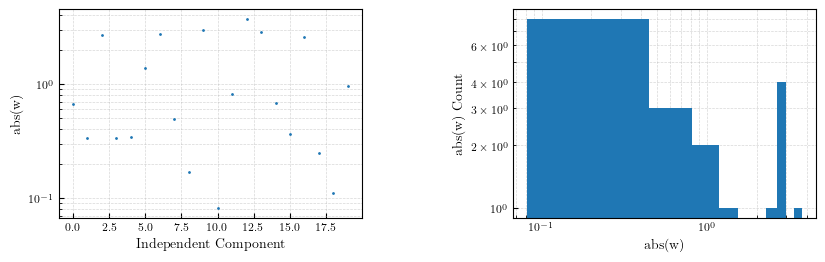

In [589]:
# plot the norm of each component of the weight vector
plot_metrics(np.abs(w), ylabel="abs(w)")

Figure size in inches:  [8.5 2.4]


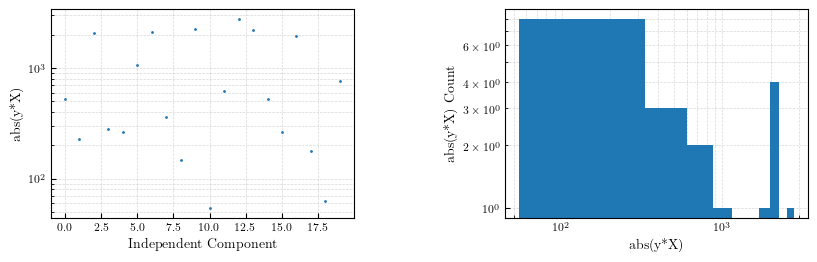

In [590]:
# compute y*X and sum over the data
yX = np.sum(y[:, np.newaxis] * X_tr, axis=0)
plot_metrics(abs(yX), ylabel="abs(y*X)")

Figure size in inches:  [8.5 2.4]


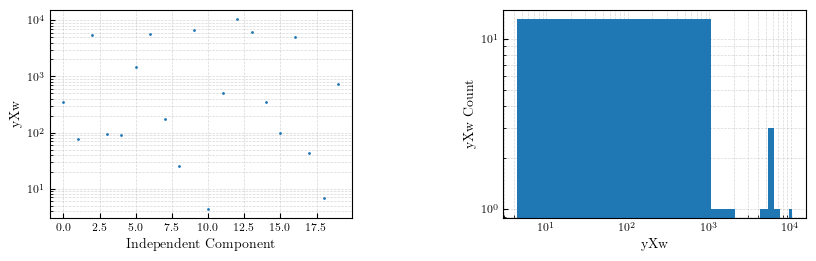

In [591]:

# compute y*X and sum over the data
yX = np.sum(y[:, np.newaxis] * X_tr, axis=0)
# compute elementwise yX * weights
yXw = yX * w
plot_metrics(yXw, ylabel="yXw")


Figure size in inches:  [8.5 2.4]


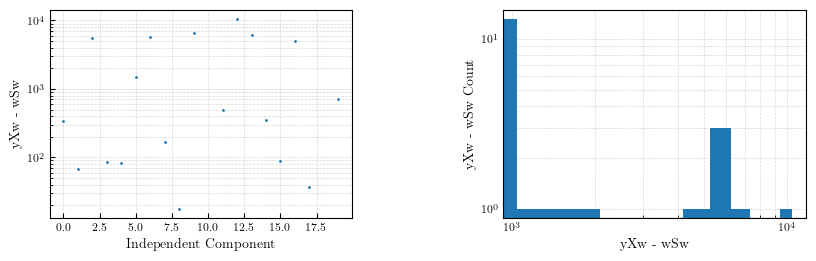

In [592]:
wSw = w.dot(sigma_upsilon).dot(w)
optimal_attack = attack_epsilon * np.sqrt(wSw)
# plot yXw - optimal_attack
attacked = yXw-optimal_attack
plot_metrics(attacked, ylabel="yXw - wSw")
